In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("./../assets/data_large_clean.csv", index_col = 0)

In [3]:
df.drop_duplicates(subset = ['education', 'clean_content'], 
                   keep = 'first',
                   inplace = True)
df.reset_index(inplace = True)

## Predict the Education Level based on the Text Content

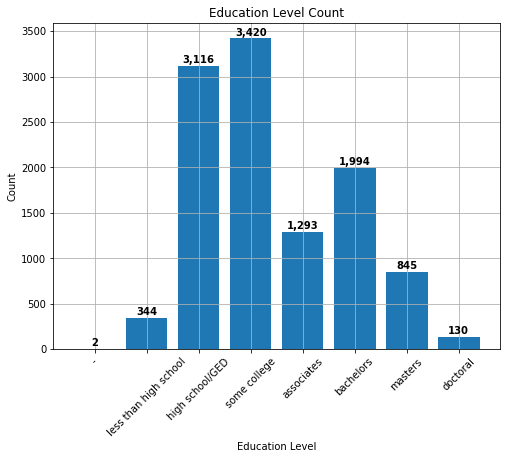

In [4]:
x = []
y = []

educ_count = df.groupby(['education']).count()
educ_count = educ_count['index'].sort_values()

educ_list = ['-',
             'less than high school',
             'high school/GED',
             'some college',
             'associates',
             'bachelors',
             'masters',
             'doctoral']

for educ in educ_list:
    x.append(educ)
    y.append(educ_count[educ])
    
plt.figure(figsize = (8,6))
plt.title("Education Level Count")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.grid()
plt.xticks(rotation=45)

for idx, value in enumerate(y):
    plt.text(x = idx, y = value + 35, 
             s = f"{value:,}", fontweight='bold', 
             horizontalalignment='center')

plt.bar(x, y);

For the purpose of this prediction, we will only predict the ones with a total count of at least 500.

In [5]:
included_educ_level = ['high school/GED',
                       'some college',
                       'associates',
                       'bachelors',
                       'masters']

df_sub = df.loc[df['education'].isin(included_educ_level)].reset_index()
df_sub.drop(['index', 'level_0', 
             'city', 'searched_zipcode',
             'url', 'content', 'posting_date', 
             'n_photos', 'availability', 
             'region', 'type of employment'], axis = 1, inplace = True)

In [6]:
print(df_sub.shape)
df_sub.nunique()

(10668, 2)


education            5
clean_content    10636
dtype: int64

MORE CLEANING

In [7]:
df_sub.loc[df_sub.duplicated(subset = 'clean_content', keep = False)].sort_values('clean_content').head(10)

,education,clean_content
7013,high school/GED,"25 year body and paint technician ,, looking f..."
7014,some college,"25 year body and paint technician ,, looking f..."
207,some college,"3yrs exp in construction ,demolition ,trenchin..."
208,high school/GED,"3yrs exp in construction ,demolition ,trenchin..."
209,some college,"3yrs exp in construction ,demolition ,trenchin..."
210,associates,"3yrs exp in construction ,demolition ,trenchin..."
1838,associates,are you looking for someone to bolster your sa...
1795,some college,are you looking for someone to bolster your sa...
2695,high school/GED,"aside from word of mouth or face to face , col..."
0,some college,"aside from word of mouth or face to face , col..."


In [8]:
df_sub = df_sub[~df_sub.duplicated(subset = 'clean_content', keep = False)]

In [9]:
print(df_sub.shape)
df_sub.nunique()

(10604, 2)


education            5
clean_content    10604
dtype: int64

In [10]:
df_sub.sample(10)

,education,clean_content
8776,high school/GED,"also have experience as a chef, server, catere..."
190,masters,i am looking for an interactive project manage...
7283,some college,"randy l. ross. 33 sanford ave. richmond, calif..."
9825,some college,roofer available. monsoon season is here and i...
3866,masters,experienced closing attorney seeks part-time w...
7975,some college,"hey there, my name is wendy. i am 63 an i have..."
2208,bachelors,serious inquiries only!!. for senior/elder/dis...
5194,bachelors,if you need help with your lawn. grass cutting...
5953,some college,my name is jenny!!! i'm looking for work! i'm ...
5546,high school/GED,thorough / reliable cleaning lady $20. per hou...


# Random Forest Classifier

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [12]:
encoder = LabelEncoder()

target = encoder.fit_transform(df_sub['education'])

In [13]:
for idx in range(10):
    print(f"{df_sub['education'].iloc[idx]}\t\t{target[idx]}")

bachelors		1
bachelors		1
some college		4
bachelors		1
masters		3
high school/GED		2
high school/GED		2
associates		0
some college		4
high school/GED		2


In [14]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english')

features = vector.fit_transform(df_sub['clean_content'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, shuffle = True)

In [16]:
rfc = RandomForestClassifier(n_estimators = 500,
                             max_depth = 30,
                             min_samples_split = 10)

In [17]:
rfc.fit(X_train, y_train);

In [18]:
train_score = rfc.score(X_train, y_train)
test_score  = rfc.score(X_test, y_test)

print(f"Training score:\t{train_score*100:.2f}%")
print(f"Testing score:\t{test_score*100:.2f}%")

Training score:	67.07%
Testing score:	45.29%


In [19]:
sample_resume = "i have a masters degree in interior architecture & design. www.lifestylesaint.com the expertise in design i have is diverse, working on projects ranging from high end residential to hotels, hotel, pip's, commercial projects, offices, building facades, renovations, multifamily, etc. some past clients include starbucks, hampton inn, la quinta and residential rehabs. no matter the size of your project, i am ready to provide solutions at good price."

In [20]:
def get_prediction(data):
    
    truth, text = data
    sample_vec = vector.transform([text])

    predict = rfc.predict(sample_vec)

    predict_class = encoder.inverse_transform(predict)
    
    print(text,"\n")
    print(f"Truth:\t\t{truth}")
    print(f"Predict:\t{predict_class[0]}")

get_prediction(df_sub.sample().values[0])

i am a female seeking work as a appointment setter.. i work from home.. i have 5 years experience and i am very good at setting appointments.. i have a bubbly voice and and a upbeat personality.. i am available 7 days a week any hours.. i have used dialer systems or make calls from my cell phone.. i have no barking dogs or children so a very quite environment.. no scammers!!!! 

Truth:		some college
Predict:	some college


# Neural Network

In [21]:
import numpy as np

import torch
import torchvision

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as utils

In [22]:
cuda = torch.cuda.is_available()

if cuda:
    print("GPU detected. Training with GPU")
else:
    print("No GPU detected. Training with CPU")

No GPU detected. Training with CPU


In [23]:
vector = CountVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 10000)

features = vector.fit_transform(df_sub['clean_content'])

In [24]:
tensor_X = torch.stack([torch.Tensor(row.todense()) for row in features])
tensor_y = torch.tensor(target)

In [25]:
dataset = utils.TensorDataset(tensor_X, tensor_y)
dataloader = utils.DataLoader(dataset, batch_size = 32,
                              shuffle = True)

In [26]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(10000, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 5)
        
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

In [27]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [28]:
epochs = 5
if cuda:
    model = model.tocuda()
for e in range(epochs):
    running_loss = 0
    for text, labels in dataloader:
        if cuda:
            text = text.tocuda()
        log_ps = model(text)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(dataloader)}")

Training loss: 1.3551863607871963
Training loss: 1.0429964254060424
Training loss: 0.5522257933864393
Training loss: 0.2984438639762531
Training loss: 0.13274543315203052


In [29]:
def model_predict(text):
    text = vector.transform(text)
    text = torch.Tensor(text)
    if cuda:
        model = model.tocuda()
        text = text.tocuda()
    predict = model(text)
    return predict

model_predict("I have a master's degree")

ValueError: Iterable over raw text documents expected, string object received.

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = (2000, 500, 100),
                    activation = 'relu',
                    solver = 'adam',
                    batch_size = 32,
                    learning_rate_init = 0.003,
                    max_iter = 5,
                    shuffle = True,
                    verbose = 1)

In [ ]:
mlp.fit(X_train, y_train)